In [76]:
import numpy as np
import pandas as pd 
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Problem 1


<img src="FE 680 HW 1 Prob 1.png" alt ='See Excel Sheet'/>

a. We filled in the sheet for the discount curve, zero curve, forward curve, and par curve. 
<br>
b. We found the pv = 123.55
<br>
c. we listed the DV01, Duration and the PV at the bottom for changes in the forward curve. 
<br>
d. We found the Convexity was 24.75
<br>
e. We estimated the forward price with blacks model as 118.76

## Problem 2

Consider a 6-month European put option on a Treasury bond that currently has 8.25 years to maturity.
The current cash bond price is 910 dollars,  the exercise price is 900 dollars, and the volatility for the bond price is 5%
per annum. A coupon of 25 dollars will be paid by the bond in three months. The risk-free interest rate is 3.5%
for all maturities up to one year. Use Black’s model to determine the price of the option. Consider both
the case where the strike price corresponds to the cash price of the bond and the case where it
corresponds to the quoted price.


In [77]:
def bond_options_price(option_type, df, K, T, F_b, sigma):
    d1 = (np.log(F_b/K)+(T*sigma**2)/2)/(sigma*np.sqrt(T))
    d2 = d1- sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = df*(F_b * norm.cdf(d1) - K * norm.cdf(d2))
    elif option_type == 'put':
        option_price = df*(K * norm.cdf(-d2) - F_b * norm.cdf(-d1))
    else:
        raise ValueError("Option type must be 'call' or 'put'.")
        
    return option_price, d1,d2    
        


In [78]:
B = 910  # Bond price t=0
T= .5 # to maturity
r = .035 # r_f interest rates
df = np.exp(-r*T) # discount factor
I =  25 * np.exp(-.25*.035) #pv of coupons in 
F_b = (B-I)/df #forward bond price
K = 900 #strike
sigma =  .05 # vol
option_type = 'put'

bond_options_price(option_type, df, K, T, F_b, sigma)[0]

12.068265789751132

In [79]:
K = 910
bond_options_price(option_type, df, K, T, F_b, sigma)[0]

17.55603197927719

The quoted price of the bond is lower than the cash price since it does not include the accrued interest. If the strike corresponds to the cash price then the put option will have a higher price since this level is higher than the quoted price it is easier for a put option to clear this hurdle and make money. 

<br>
<br>
In this case the price of the put option is 12.07

## Problem 3

In [80]:
def cubic_spline_coeff(maturities, yields):
    t= maturities
    
    n = len(yields)
    A = np.zeros((n+2,n+2)) 
    rates = np.append(yields , [0,0])
    ## j = col, i = row
    for i in range(n):
        for j in range(n+2):
            if j == 0:
                A[i,j] = 1
            elif j==1:
                A[i,j] = (t[i]-t[0])
            elif j==2:
                A[i,j] = (t[i]-t[0])**2
            else:
                A[i,j]= max((t[i]-t[j-3]),0)**3
                
    for i in range(n,n+2):
        for j in range(n+2):
            if j==2:
                A[i,j] = 2
            elif j>2 and i == n+1:
                A[i,j] = 6*(t[n-1]-t[j-3])
                
    coeff = np.linalg.solve(A, rates)
    
    return A, rates, coeff

In [180]:
maturities = np.array([.25, .5, 1, 2, 5, 10, 20])  # Maturities in years
yields = np.array([3.2, 3.23, 3.3, 3.55, 4.1, 4.5, 4.72])  # Corresponding yields

coeff = cubic_spline_coeff(maturities, yields)[2] 
a = coeff[0]
b = coeff[1]
c = coeff[2]
ds = coeff[3:]

With these coefficients we get the formula:
<br>
\begin{equation}
R(0,t) = 3.2 + .12(t-t_{1}) + 1.84*10^{(-16)}(t-t_{1})^{2} + \sum_{k=1}^{n-1} d_{k}(t-t_{k})_{+}^{3}
\end{equation}
where 
\begin{equation}
\sum_{k=1}^{n-1} d_{k}(t-t_{k})_{+}^{3} = -0.00093891(t-t_{1})_{+}^{3} + 0.08281672(t-t_{2})_{+}^{3} + -0.13457716(t-t_{3})_{+}^{3} + 0.05543003(t-t_{4})_{+}^{3} + -0.00222994(t-t_{5})_{+}^{3} + -0.00037079(t-t_{6})_{+}^{3}
\end{equation}

In [181]:
def estimate_yield_rate(a, b, c, ds, t, maturities):
    cube_term = 0
    for i in range(len(ds)):
        add = ds[i]*max((t-maturities[i])**3,0)
        cube_term = cube_term + add
    
    r = a + b*(t-maturities[0]) + c*((t-maturities[0])**2) + cube_term
    return r


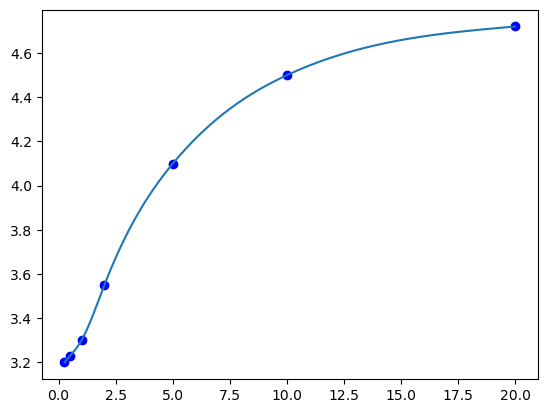

In [182]:
ts = np.arange(.25, 20, .01)
yield_curve = []
for t in ts:
    y = estimate_yield_rate(a, b, c, ds, t, maturities)
    yield_curve.append(y)
plt.scatter(maturities, yields, color='blue')
plt.plot(ts, yield_curve)
plt.show()

In [84]:
estimate_yield_rate(a,b,c,ds, 4, maturities)

3.961330971000337

The yield rate for t = 4 is 3.96%

## Problem 4

In [85]:
df = pd.read_csv(r"C:\Users\bjorn\FE 680 Advanced Derivatives\HW1_data_for_Problem_4_S24.csv")
df['Coupon rate'] = df['Coupon rate'].str[:-1]
df['Coupon rate'] = df['Coupon rate'].astype(float)
df['Coupon rate'] = df['Coupon rate']*.01

In [86]:
df.head(3)

,Time to next payment,Payment frequency,Time to maturity,Coupon rate,Clean Price
0,0.4356,2,0.4356,0.0088,100.30
1,0.2644,2,0.7644,0.0088,100.48
2,0.2658,2,1.2658,0.0075,100.50


In [87]:
df['Accrued Interest'] = 100*(df['Coupon rate']/df['Payment frequency'])*((1/df['Payment frequency'])-df['Time to next payment'])*2
df['Dirty Price'] = df['Clean Price'] + df['Accrued Interest']

In [101]:
df

,Time to next payment,Payment frequency,Time to maturity,Coupon rate,Clean Price,Accrued Interest,Dirty Price
0,0.4356,2,0.4356,0.0088,100.30,0.056672,100.356672
1,0.2644,2,0.7644,0.0088,100.48,0.207328,100.687328
2,0.2658,2,1.2658,0.0075,100.50,0.175650,100.675650
3,0.4342,2,1.9342,0.0063,100.31,0.041454,100.351454
4,0.0192,2,2.0192,0.0038,99.78,0.182704,99.962704
5,0.4753,2,2.9753,0.0075,100.16,0.018525,100.178525
6,0.3534,2,3.3534,0.0150,102.34,0.219900,102.559900
7,0.1000,2,3.6000,0.0175,103.08,0.700000,103.780000
8,0.2685,2,4.2685,0.0213,104.19,0.493095,104.683095
9,0.4342,2,4.9342,0.0175,102.06,0.115150,102.175150


In [127]:
clean_prices = df['Clean Price'].to_numpy()
coupons = df['Coupon rate'].to_numpy()
ttms = df['Time to maturity'].to_numpy()
dirty_prices = df['Dirty Price'].to_numpy()
mats = ttms

In [170]:
def objective_function(params, mats, dirty_prices):
    beta0, beta1, beta2, lamb = params
    predicted_yields = beta0 + beta1 * ((1 - np.exp(-mats* lamb)) / (mats * lamb)) + beta2 * (((1 - np.exp(-mats * lamb)) / (mats * lamb)) - np.exp(-mats * lamb))
    predicted_yields = predicted_yields
    theoretical_prices = []
    for i in range(len(dirty_prices)):
        j = 0
        theo_price = 0 
        time_to_present = df['Time to next payment'][i]
        time_track = ttms[i]    
        while time_track > 0 :
            if j == 0:
                theo_price = theo_price + coupons[i]*50 * np.exp(-predicted_yields * time_to_present)
                time_track = round(time_track -  df['Time to next payment'][i],5)
                j=j+1
                time_to_present = round(time_to_present+1/df['Payment frequency'][i],5)
            else:
                theo_price = theo_price + coupons[i]*50 * np.exp(-predicted_yields * time_to_present)
                time_track = round(time_track - .5,5)
                time_to_present = round(time_to_present+1/df['Payment frequency'][i],5)
                j=j+1
        
        theo_price = theo_price + 100*np.exp(-predicted_yields * time_to_present)
        theoretical_prices.append(theo_price)   
    return np.sum((theoretical_prices - dirty_prices) ** 2)


initial_guess = [0.0, 0.0, 0.0, 2.0]

cons = ({'type': 'ineq', 'fun': lambda x: x[0]},   
        {'type': 'ineq', 'fun': lambda x: x[0] + x[1]},  
        {'type': 'ineq', 'fun': lambda x: x[3]})  


result = minimize(objective_function, initial_guess, args=(mats, dirty_prices),constraints=cons, method = 'Powell')
estimated_params = result.x


print("Estimated Parameters:", estimated_params)


C:\Users\bjorn\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:576: RuntimeWarning: Method Powell cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
C:\Users\bjorn\AppData\Local\Temp\ipykernel_22712\2975509216.py:13: RuntimeWarning: overflow encountered in exp
  theo_price = theo_price + coupons[i]*50 * np.exp(-predicted_yields * time_to_present)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_22712\2975509216.py:23: RuntimeWarning: overflow encountered in exp
  theo_price = theo_price + 100*np.exp(-predicted_yields * time_to_present)
C:\Users\bjorn\AppData\Local\Temp\ipykernel_22712\2975509216.py:18: RuntimeWarning: overflow encountered in exp
  theo_price = theo_price + coupons[i]*50 * np.exp(-predicted_yields * time_to_present)


Estimated Parameters: [0.02837981 0.01292967 0.00251926 0.24080737]


We get the following parameters for the Nelson-Siegel model:
\begin{equation}
\beta_{0} = .02837981, \beta_{1} = .01292967, \beta_{2} = .00251926, and \lambda = .24080737
\end{equation}

These may be incorrect however since the parameters are so small I wonder if the minimization program struggles to compute this.